In [1]:
import pandas as pd
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import boto3
from botocore.exceptions import NoCredentialsError
from minio import Minio

In [2]:
# Set your MinIO server credentials
minio_endpoint = "http://localhost:9000"
minio_access_key = "minioadmin"
minio_secret_key = "minioadmin"
minio_bucket_name = "parquetfiles"
minio_file_name = "heart_attack_prediction_dataset.csv.parquet"

# Download the Parquet file from MinIO
def download_file_from_minio():
    try:
        s3 = boto3.client(
            "s3",
            endpoint_url=minio_endpoint,
            aws_access_key_id=minio_access_key,
            aws_secret_access_key=minio_secret_key,
        )

        with open(minio_file_name, "wb") as f:
            s3.download_fileobj(minio_bucket_name, minio_file_name, f)

    except NoCredentialsError:
        print("Credentials not available")

In [4]:
# Download the file
download_file_from_minio()

# Read the Parquet file into a Pandas DataFrame
table = pq.read_table(minio_file_name)
df = table.to_pandas()
df

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,MSV9918,60,Male,121,94/76,61,1,1,1,0,...,10.806373,235420,19.655895,67,7,7,Thailand,Asia,Northern Hemisphere,0
8759,QSV6764,28,Female,120,157/102,73,1,0,0,1,...,3.833038,217881,23.993866,617,4,9,Canada,North America,Northern Hemisphere,0
8760,XKA5925,47,Male,250,161/75,105,0,1,1,1,...,2.375214,36998,35.406146,527,4,4,Brazil,South America,Southern Hemisphere,1
8761,EPE6801,36,Male,178,119/67,60,1,0,1,0,...,0.029104,209943,27.294020,114,2,8,Brazil,South America,Southern Hemisphere,0


In [5]:
# Data preprocessing
# Split 'Blood Pressure' into two separate columns
df[['Systolic Pressure', 'Diastolic Pressure']] = df['Blood Pressure'].str.split('/', expand=True)

# Convert to numeric
df['Systolic Pressure'] = pd.to_numeric(df['Systolic Pressure'], errors='coerce')
df['Diastolic Pressure'] = pd.to_numeric(df['Diastolic Pressure'], errors='coerce')


In [6]:
# Adjust the following based on your dataset columns
features = df[['Age', 'Cholesterol', 'Systolic Pressure', 'Diastolic Pressure', 'BMI', 'Physical Activity Days Per Week']]
target = df['Heart Attack Risk']

In [7]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build and train the model 
model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [8]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6417569880205363

Confusion Matrix:
 [[1125    0]
 [ 628    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       0.00      0.00      0.00       628

    accuracy                           0.64      1753
   macro avg       0.32      0.50      0.39      1753
weighted avg       0.41      0.64      0.50      1753



C:\Users\ilham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471

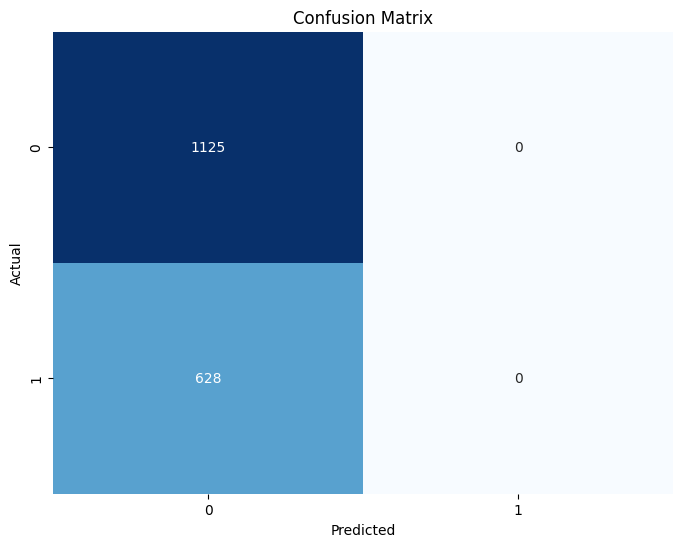

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()